## Лабораторная работа № 4
-----
### Визуальная одометрия

В данной работе предлагается реализовать алгоритм визуальной одометрии для нахождения траектории движения мобильного робота.


**В данной работе необходимо:**
- Выявить коючевые точки(признаки) на изображениях, которые были сделаны с помощью камеры, установленной на движущемся объекте.
- Использовать извлеченные признаки, чтобы найти совпадения между ними на разных фотографиях.
- Использовать найденные совпадения для оценки движения камеры между последующими фотографиями.
- Использовать оценку движения камеры для построения траектории движения объекта.

Для большинства задач вам предоставляется рекомендуемый план. Но если вы считаете, что есть лучший и более эффективный способ решения проблемы, то можно отклоняться.

Скачивание необходимых файлов

In [ ]:
!gdown 1crStkNUxzYAauelhrx_lZ__XPuVIw69a

Downloading...
From (original): https://drive.google.com/uc?id=1crStkNUxzYAauelhrx_lZ__XPuVIw69a
From (redirected): https://drive.google.com/uc?id=1crStkNUxzYAauelhrx_lZ__XPuVIw69a&confirm=t&uuid=bcd75fcc-2ea7-4ede-9aae-56fd9a30e10e
To: /content/lab4_files.rar
100% 97.7M/97.7M [00:00<00:00, 212MB/s]


In [ ]:
#!unrar x /content/lab4_files.rar #извекаем файлы из архива

In [ ]:
!python /content/lab4_files/m2bk.py

Подключаем необходимые библиотеки

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from lab4_files.m2bk import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0 - Загрузка и визуализация данных
Удобный класс обработчика набора данных для чтения и итерирования по ним доступен в локальном пакете. Данные взяты из симулятора CARLA. Запустите следующий код, чтобы создать объект обработчика набора данных.

In [ ]:
dataset_handler = DatasetHandler()

Обработчик набора данных содержит 52 кадра. Каждый кадр содержит изображение RGB и карту глубины, полученную с одинаковым интервалом времени при движении на транспортном средстве, и версию изображения RGB в градациях серого, которая будет использоваться для вычислений.

Готовая матрица калибровки камеры **K** также хранится в обработчике набора данных.

При создании объекта обработчика набора данных все кадры будут автоматически прочитаны и загружены. Доступ к содержимому кадра можно получить с помощью аттрибутов `images`, `images_rgb`, `depth_maps` вместе с номером запрошенного кадра. Посмотрите, как получить доступ к изображениям (оттенки серого), изображениям RGB (3-канальный цвет), картам глубины и матрице калибровки камеры в приведенном ниже примере.

**Примечание (карты глубины)**: Максимальное расстояние глубины равно 1000. Это значение глубины показывает, что выбранный пиксель находится на расстоянии не менее 1000 м (1 км) от камеры, однако точное расстояние этого пикселя от камеры неизвестно. Наличие таких точек в дальнейшей оценке траектории может повлиять на точность траектории.

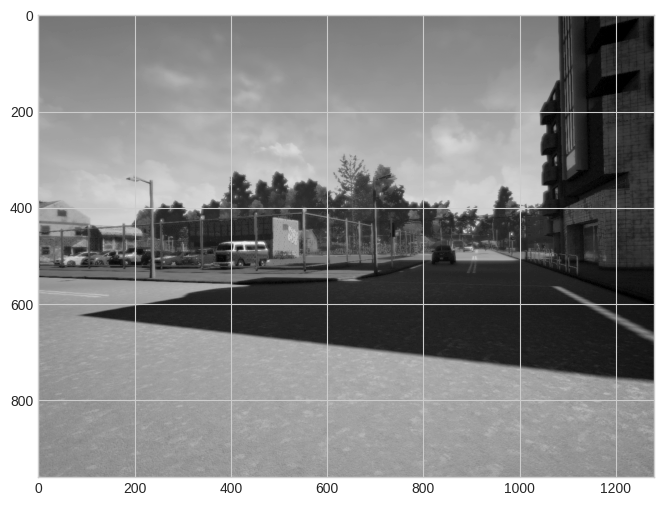

In [ ]:
image = dataset_handler.images[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

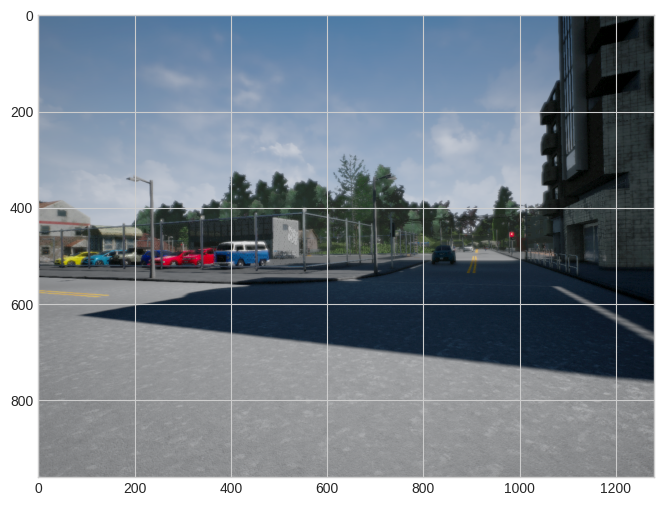

In [ ]:
image_rgb = dataset_handler.images_rgb[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_rgb)

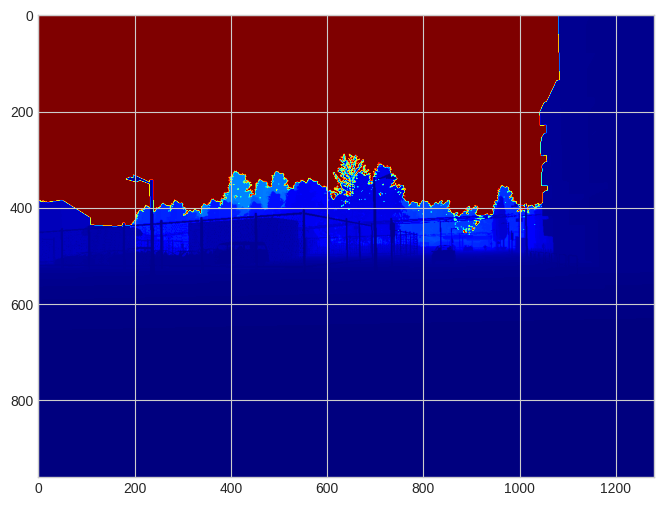

In [ ]:
i = 0
depth = dataset_handler.depth_maps[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(depth, cmap='jet')

In [ ]:

depth

array([[1000.   , 1000.   , 1000.   , ...,   14.607,   14.6  ,   14.593],
       [1000.   , 1000.   , 1000.   , ...,   14.607,   14.6  ,   14.593],
       [1000.   , 1000.   , 1000.   , ...,   14.607,   14.6  ,   14.593],
       ...,
       [   1.972,    1.971,    1.971, ...,    1.87 ,    1.87 ,    1.87 ],
       [   1.967,    1.967,    1.967, ...,    1.866,    1.866,    1.866],
       [   1.963,    1.963,    1.963, ...,    1.863,    1.863,    1.862]])

In [ ]:
print("Размеры карты глубин: {0}".format(depth.shape))
v, u = depth.shape
depth_val = depth[v-1, u-1]
print("Значение глубины самого нижнего правого пикселя карты глубины кадры {0} равно {1:0.3f}".format(i, depth_val))

Размеры карты глубин: (960, 1280)
Значение глубины самого нижнего правого пикселя карты глубины кадры 0 равно 1.862


In [ ]:
dataset_handler.k

array([[640.,   0., 640.],
       [  0., 480., 480.],
       [  0.,   0.,   1.]], dtype=float32)

Для доступа к произвольному кадру используйте индекс изображения, как показано в примерах ниже. Убедитесь, что индексы находятся в пределах количества кадров в наборе данных. Доступ к количеству кадров в наборе данных можно получить с помощью атрибута num_frames.

In [ ]:
# Number of frames in the dataset
print(dataset_handler.num_frames)

52


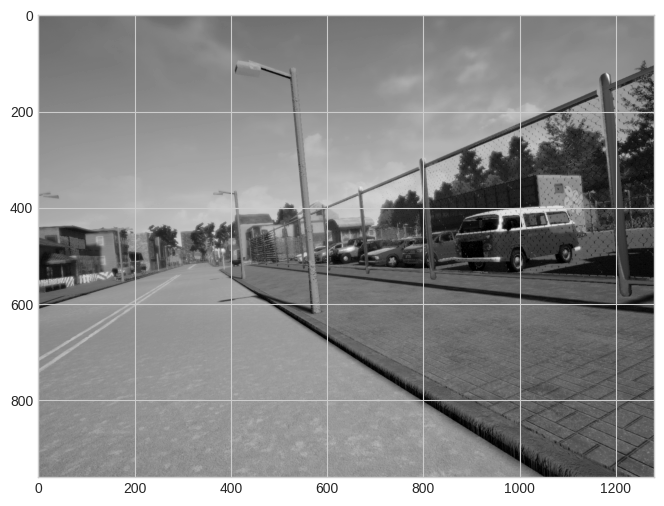

In [ ]:
i = 35
image = dataset_handler.images[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

## 1 - Извлечение признаков

### 1.1 - Извлечение признаков из изображения

**Задание**: Реализовать извлечение признаков из одного изображения. Вы можете использовать любой дескриптор признаков по вашему выбору, например, ORB или SIFT.



***Опционально***: Попробуйте извлечь функции с разными дескрипторами, такими как SIFT, ORB, SURF и BRIEF. Вы также можете попробовать использовать детекторы, такие как углы Харриса или FAST, и соединить их с дескриптором. Наконец, попробуйте изменить параметры алгоритмов.

In [ ]:
def extract_features(image):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    ### START CODE HERE ###

    # Инициализация детектора ORB
    orb = cv2.ORB_create(nfeatures=500)
    # Нахождение ключевых точек и дескрипторов
    kp, des = orb.detectAndCompute(image, None)


    ### END CODE HERE ###

    return kp, des

In [ ]:
i = 1
image = dataset_handler.images[i]
kp, des = extract_features(image)
print("Количество объектов, обнаруженных в кадре {0}: {1}\n".format(i, len(kp)))

print("Координаты первой ключевой точки в кадре {0}: {1}".format(i, str(kp[0].pt)))

Количество объектов, обнаруженных в кадре 1: 500

Координаты первой ключевой точки в кадре 1: (301.0, 400.0)


In [ ]:
def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(display)

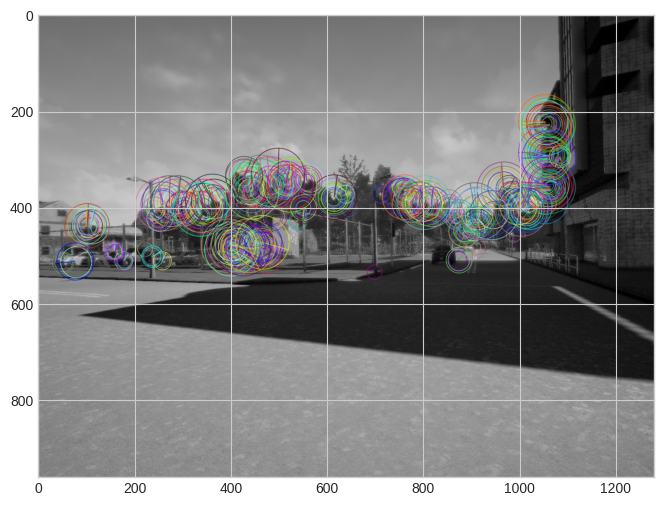

In [ ]:
# Optional: visualizing and experimenting with various feature descriptors
i = 0
image = dataset_handler.images[i]

visualize_features(image, kp)

### 1.2 - Извлечение признаков из каждого изображения в наборе данных

**Task**: Реализуйте извлечение признаков для каждого изображения в наборе данных с помощью функции, которую вы написали в предыдущем разделе.


In [ ]:
def extract_features_dataset(images, extract_features_function):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images

    """
    kp_list = []
    des_list = []

    ### START CODE HERE ###

    # Итерация по каждому изображению в списке
    for image in images:
        # Используем переданную функцию для извлечения признаков
        kp, des = extract_features_function(image)
        # Добавляем полученные ключевые точки и дескрипторы в соответствующие списки
        kp_list.append(kp)
        des_list.append(des)



    ### END CODE HERE ###

    return kp_list, des_list

In [ ]:
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)

i = 1
print("Количество признаков обнаружено в кадре {0}: {1}".format(i, len(kp_list[i])))
print("Координаты первой ключевой точки в кадре {0}: {1}\n".format(i, str(kp_list[i][0].pt)))

# Remember that the length of the returned by dataset_handler lists should be the same as the length of the image array
print("Длина массива изображений: {0}".format(len(images)))

Количество признаков обнаружено в кадре 1: 500
Координаты первой ключевой точки в кадре 1: (301.0, 400.0)

Длина массива изображений: 52


## 2 - Сопоставление признаков

Следующим шагом после извлечения признаков в каждом изображении является сопоставление признаков из последующих кадров. Это то, что необходимо сделать в этом разделе.

### 2.1 - Сопоставление признаков из пары последующих кадров

**Задание**: Реализовать сопоставление признаков для пары изображений. Вы можете использовать любой алгоритм сопоставления признаков по вашему выбору, описанный в лекциях, например, Brute Force Matching или сопоставление на основе FLANN.

***Подсказка(опционально)***: Реализуйте фильтрацию совпадений, устанавливая пороговое значение расстояния между лучшими совпадениями. Это может быть полезно для улучшения общих результатов оценки траектории. Напомним, что у вас есть возможность указать количество наилучших совпадений, которые должны быть возвращены сопоставителем.

Мы предоставили визуализацию найденных совпадений. Все совпадения кажутся вам справедливыми? Считаете ли вы, что фильтрация совпадений может улучшить ситуацию?

In [ ]:
def match_features(des1, des2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    ### START CODE HERE ###
    # Создание BF сопоставителя с расстоянием Hamming
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Сопоставление дескрипторов
    matches = bf.match(des1, des2)
    # Сортировка совпадений по расстоянию (лучшие первые)
    matches = sorted(matches, key=lambda x: x.distance)


    ### END CODE HERE ###

    return matches

In [ ]:
i = 0
des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
print("Количество признаков, совпадающих в кадрах {0} и {1}: {2}".format(i, i+1, len(match)))

# Remember that a matcher finds the best matches for EACH descriptor from a query set
# Помните, что средство сопоставления находит наилучшие соответствия для каждого дескриптора из набора запросов

Количество признаков, совпадающих в кадрах 0 и 1: 333


In [ ]:
# Optional
def filter_matches_distance(match, dist_threshold):
    """
    Отфильтруйте совпадающие объекты на двух изображениях по расстоянию между наилучшими совпадениями

    Arguments:
    match -- список совпадающих элементов на двух изображениях
    dist_threshold -- максимально допустимое относительное расстояние между лучшими совпадениями, (0.0, 1.0)


    Returns:
    filtered_match -- список хороших совпадений, удовлетворяющих пороговому значению расстояния
    """
    filtered_match = []

    ### START CODE HERE ###
    # Определите максимальное расстояние на основе минимального расстояния, найденного в совпадениях
    if match:
        min_distance = min(m.distance for m in match)  # минимальное расстояние
        max_allowed_distance = min_distance * (1 + dist_threshold)  # пороговое значение
        # Отфильтровываем совпадения, расстояние между которыми меньше расчетного максимально допустимого расстояния
        filtered_match = [m for m in match if m.distance <= max_allowed_distance]
        print("saffaf\n",min_distance)
        print("saffaf\n",max_allowed_distance)







    ### END CODE HERE ###

    return filtered_match

In [ ]:
# Optional
i = 0
des1 = des_list[i]
des2 = des_list[i+1]
match = match_features(des1, des2)
dist_threshold = 15
filtered_match = filter_matches_distance(match, dist_threshold)

print("Количество совпадений в кадрах {0} и {1} после фильтрации по расстоянию: {2}".format(i, i+1, len(filtered_match)))

saffaf
 4.0
saffaf
 64.0
Количество совпадений в кадрах 0 и 1 после фильтрации по расстоянию: 330


In [ ]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

saffaf
 1.0
saffaf
 16.0
42


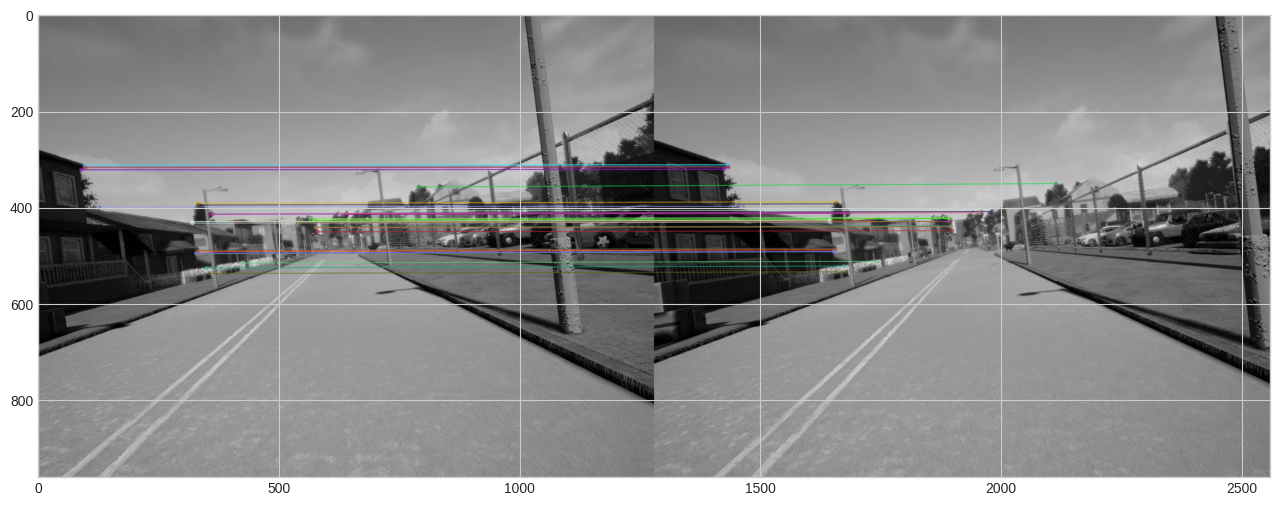

In [ ]:
# Визуализируйте первые n совпадений, поставьте n = None чтобы отобразить все совпадения
# установите filtering = True если хотите использовать фильтрацию совпадений, иначе поставьте False
n = None
filtering = True

i = 41
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
if filtering:
    dist_threshold = 15
    match = filter_matches_distance(match, dist_threshold)

print(len(match))

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])

### 2.2 - Сопоставление признаков в каждой последующей паре изображений в наборе данных

**Задание**: Реализуйте сопоставление признаков для каждой последующей пары изображений в наборе данных с помощью функции, которую вы написали в предыдущем разделе.

***Опционально***: Реализуйте фильтрацию соответствия, устанавливая пороговое значение расстояния для каждой последующей пары изображений в наборе данных с помощью функции, которую вы написали в предыдущем разделе.

In [ ]:
def match_features_dataset2(des_list, match_features):
    """
    Сопоставьте объекты для каждой последующей пары изображений в наборе данных

    Arguments:
    des_list --  список дескрипторов для каждого изображения в наборе данных
    match_features -- функция, которая сопоставляет объекты между парой изображений

    Returns:
    matches -- список совпадений для каждой последующей пары изображений в наборе данных.
               Each matches[i] is a list of matched features from images i and i + 1

    """
    matches = []

    ### START CODE HERE ###

     # Проходим по списку дескрипторов и сопоставляем признаки для каждой последовательной пары
    for i in range(len(des_list) - 1):
        # Получаем дескрипторы для текущего и следующего изображения
        des1 = des_list[i]
        des2 = des_list[i + 1]

        # Сопоставляем признаки между этими двумя наборами дескрипторов
        match = match_features(des1, des2)

        # Добавляем результат сопоставления в список matches
        matches.append(match)


    ### END CODE HERE ###

    return matches

In [ ]:
def match_features_dataset(des_list, match_features):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which matches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset.
               Each matches[i] is a list of matched features from images i and i + 1

    """
    matches = []

    ### START CODE HERE ###
    # Iterate through all the descriptors in the list except the last one
    for i in range(len(des_list) - 1):
        # Match features between the current descriptor and the next one
        match = match_features(des_list[i], des_list[i + 1])
        # Append the results to the matches list
        matches.append(match)
    ### END CODE HERE ###

    return matches

In [ ]:
matches = match_features_dataset(des_list, match_features)

i = 0
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

Number of features matched in frames 0 and 1: 333


In [ ]:
# Optional
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold):
    """
    Отфильтруйте совпадающие объекты по расстоянию для каждой последующей пары изображений в наборе данных

    Arguments:
    filter_matches_distance -- функция, которая фильтрует совпадающие объекты на двух изображениях по расстоянию между наилучшими совпадениями
    matches -- список совпадений для каждой последующей пары изображений в наборе данных.
               Каждое matches[i] это список совпадающих объектов из изображений i и i + 1
    dist_threshold -- максимально допустимое относительное расстояние между наилучшими совпадениями, (0.0, 1.0)

    Returns:
    filtered_matches --  список хороших совпадений для каждой последующей пары изображений в наборе данных.

    """
    filtered_matches = []

    ### START CODE HERE ###

    # Проход по всем совпадениям в наборе данных
    for match in matches:
        # Применение функции фильтрации по расстоянию к каждому списку совпадений
        filtered_match = filter_matches_distance(match, dist_threshold)
        # Добавление отфильтрованных совпадений в результат
        filtered_matches.append(filtered_match)


    ### END CODE HERE ###

    return filtered_matches

In [ ]:
# Optional
dist_threshold = 15

filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)

if len(filtered_matches) > 0:

    #Убедитесь, что для этой переменной установлено значение True, если вы хотите в дальнейшем использовать отфильтрованные совпадения в своем задании
    is_main_filtered_m = True
    if is_main_filtered_m:
        matches = filtered_matches

    i = 0
    print("Количество отфильтрованных совпадений во фреймах {0} and {1}: {2}".format(i, i+1, len(filtered_matches[i])))

saffaf
 4.0
saffaf
 64.0
saffaf
 4.0
saffaf
 64.0
saffaf
 4.0
saffaf
 64.0
saffaf
 3.0
saffaf
 48.0
saffaf
 3.0
saffaf
 48.0
saffaf
 3.0
saffaf
 48.0
saffaf
 2.0
saffaf
 32.0
saffaf
 2.0
saffaf
 32.0
saffaf
 3.0
saffaf
 48.0
saffaf
 3.0
saffaf
 48.0
saffaf
 4.0
saffaf
 64.0
saffaf
 4.0
saffaf
 64.0
saffaf
 9.0
saffaf
 144.0
saffaf
 6.0
saffaf
 96.0
saffaf
 5.0
saffaf
 80.0
saffaf
 3.0
saffaf
 48.0
saffaf
 4.0
saffaf
 64.0
saffaf
 2.0
saffaf
 32.0
saffaf
 4.0
saffaf
 64.0
saffaf
 3.0
saffaf
 48.0
saffaf
 7.0
saffaf
 112.0
saffaf
 7.0
saffaf
 112.0
saffaf
 6.0
saffaf
 96.0
saffaf
 3.0
saffaf
 48.0
saffaf
 6.0
saffaf
 96.0
saffaf
 6.0
saffaf
 96.0
saffaf
 7.0
saffaf
 112.0
saffaf
 8.0
saffaf
 128.0
saffaf
 4.0
saffaf
 64.0
saffaf
 5.0
saffaf
 80.0
saffaf
 4.0
saffaf
 64.0
saffaf
 9.0
saffaf
 144.0
saffaf
 10.0
saffaf
 160.0
saffaf
 7.0
saffaf
 112.0
saffaf
 6.0
saffaf
 96.0
saffaf
 7.0
saffaf
 112.0
saffaf
 7.0
saffaf
 112.0
saffaf
 8.0
saffaf
 128.0
saffaf
 5.0
saffaf
 80.0
saffaf
 5.0
s

## 3 - Оценка траектории

На данном этапе есть все, чтобы реализовать визуальную одометрию. В этом разделе вы будете постепенно оценивать положение исследуя изменения на изображении с бортовой камеры, которые вызывает движение.

### 3.1 - Оценка движения камеры между парой изображений

**Задание**: Реализуйте оценку движения камеры по паре изображений. Вы можете использовать алгоритм оценки движения Perspective-n-Point (PnP) или Essential Matrix Decomposition.

- Если вы решите использовать PnP, вам понадобятся карты глубины кадра, и они предоставляются с обработчиком набора данных.


***Опционально***: Реализуйте оценку движения камеры с помощью PnP, PnP с RANSAC и Essential Matrix Decomposition. Посмотрите, как фильтрация совпадений по расстоянию меняет расчетное движение камеры. Вы видите разницу в различных подходах?

In [ ]:
'''
def estimate_motion22222(match, kp1, kp2, k, depth1=None):
    """
    Оцените движение камеры по паре последующих кадров изображения

    Arguments:
    match -- список совпадающих объектов на паре изображений
    kp1 -- список ключевых точек на первом изображении
    kp2 -- список ключевых точек на втором изображении
    k -- матрица калибровки камеры

    Optional arguments:
    depth1 -- карта глубины первого кадра. Этот аргумент не нужен, если вы используете базовую матричную декомпозицию

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- список выбранных координат совпадения на первом изображении. image1_points[i] = [u, v], где u и v - координаты i-го совпадения в системе координат изображения.
    image2_points -- список выбранных координат совпадения на втором изображении. image1_points[i] = [u, v], где u и v - координаты i-го совпадения в системе координат изображения.

    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = [] # in 2D
    image2_points = [] # in 2D
    objectpoints = [] # in 3D

    ### START CODE HERE ###




    ### END CODE HERE ###

    return rmat, tvec, image1_points, image2_points
'''

In [ ]:
def estimate_motion0(matches, kp1, kp2, k, depth1=None):
    # Выбор точек из сопоставлений
    image1_points = np.float32([kp1[m.queryIdx].pt for m in matches])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Преобразование точек в координаты в 3D, используя карту глубины
    object_points = np.float32([depth1[int(pt[1]), int(pt[0])] * np.linalg.inv(k) @ [pt[0], pt[1], 1] for pt in image1_points])

    # Оценка движения с помощью solvePnP
    _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
    rmat, _ = cv2.Rodrigues(rvec)

    return rmat, tvec, image1_points[inliers[:,0]], image2_points[inliers[:,0]]


In [ ]:
import numpy as np
import cv2
'''
def estimate_motion1(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames using the PnP algorithm.
    """
    # Инициализация списков для координат точек
    image1_points = [] # in 2D
    image2_points = [] # in 2D
    object_points = [] # in 3D

    # Проверка каждого совпадения
    for m in match:
        # Получение координат точек сопоставления
        pt1 = kp1[m.queryIdx].pt
        pt2 = kp2[m.trainIdx].pt
        image1_points.append(pt1)
        image2_points.append(pt2)

        # Использование глубины для получения 3D координат
        if depth1 is not None:
            # Получение значения глубины
            depth_value = depth1[int(pt1[1]), int(pt1[0])]
            if depth_value > 0:  # Проверка на положительную глубину
                # Преобразование из пиксельных координат в мировые координаты
                x = (pt1[0] - k[0][2]) * depth_value / k[0][0]
                y = (pt1[1] - k[1][2]) * depth_value / k[1][1]
                object_points.append([x, y, depth_value])
            else:
                continue

    # Проверка на достаточное количество точек для PnP
    if len(object_points) < 4:
        print("Недостаточно достоверных 3D-точек для оценки движения.")
        return None, None, [], []

    object_points = np.array(object_points, dtype=np.float32)
    image2_points = np.array(image2_points, dtype=np.float32)

    # Выполнение PnP
    _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
    rmat, _ = cv2.Rodrigues(rvec)

    # Отфильтровать точки, которые не входят в inliers
    image1_points = np.array(image1_points, dtype=np.float32)[inliers[:, 0], :]
    image2_points = np.array(image2_points, dtype=np.float32)[inliers[:, 0], :]

    return rmat, tvec, image1_points, image2_points
'''

In [ ]:
def estimate_motion(matches, kp1, kp2, k, depth1=None):
    if len(matches) < 4:
        print("Недостаточно точек для оценки движения.")
        return None  # Или возвращайте единичную матрицу и нулевой вектор

    image1_points = np.float32([kp1[m.queryIdx].pt for m in matches])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in matches])

    if depth1 is not None:
        object_points = []
        for pt in image1_points:
            d = depth1[int(pt[1]), int(pt[0])]
            if d > 0:  # Проверяем, что глубина положительная
                obj_pt = d * np.linalg.inv(k) @ [pt[0], pt[1], 1]
                object_points.append(obj_pt)
            else:
                print(f"Невалидное значение глубины: {d} в точке {pt}")

        if len(object_points) < 4:
            print("Недостаточно валидных 3D точек для оценки движения.")
            return None  # Или возвращайте единичную матрицу и нулевой вектор

        object_points = np.float32(object_points)
    else:
        print("Карта глубины отсутствует.")
        return None

    # Продолжение работы функции
    # RANdom SAmple Consensus
    _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
    rmat, _ = cv2.Rodrigues(rvec)

    return rmat, tvec, image1_points[inliers[:,0]], image2_points[inliers[:,0]]


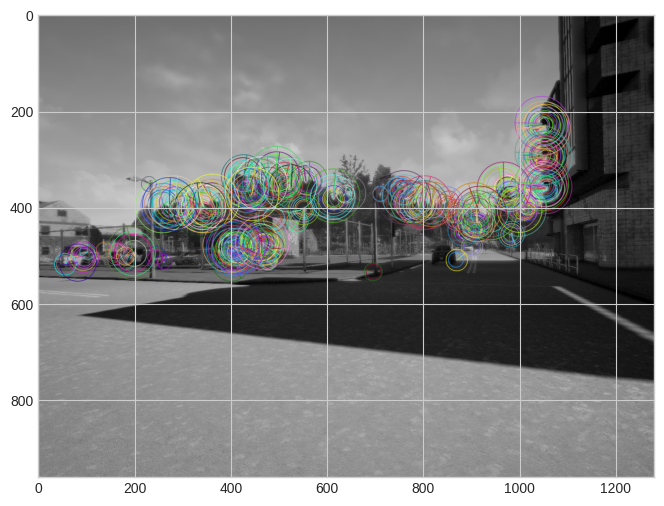

In [ ]:
visualize_features(image, kp_list[0])

In [ ]:
i = 0

match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k = dataset_handler.k
depth = dataset_handler.depth_maps[i]

rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1=depth)


print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))


Estimated rotation:
 [[ 0.99998075 -0.00580075  0.00220269]
 [ 0.00580432  0.99998185 -0.00161708]
 [-0.00219327  0.00162983  0.99999627]]
Estimated translation:
 [[-0.02718762]
 [ 0.02136037]
 [-0.29928727]]


In [ ]:
len(image1_points)

327

**Ожидаемый формат вывода**:

Убедитесь, что ваша предполагаемая матрица вращения и вектор перемещения имеют тот же формат, что и заданные начальные значения.

```
rmat = np.eye(3)
tvec = np.zeros((3, 1))

print("Initial rotation:\n {0}".format(rmat))
print("Initial translation:\n {0}".format(tvec))
```


```
Initial rotation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Initial translation:
 [[0.]
 [0.]
 [0.]]
```

**Визуализация движения камеры**:
Вы можете использовать `visualize_camera_movement` доступный в локальном пакете. Эта функция визуализирует окончательные совпадения изображений из пары изображений, соединенных стрелкой, соответствующей направлению движения камеры. (when `is_show_img_after_mov = False`). Описание функции:
```
Arguments:
image1 -- the first image in a matched image pair (RGB or grayscale)
image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [x, y], where x and y are
                 coordinates of the i-th match in the image coordinate system
image2 -- the second image in a matched image pair (RGB or grayscale)
image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [x, y], where x and y are
                 coordinates of the i-th match in the image coordinate system
is_show_img_after_mov -- a boolean variable, controling the output (read image_move description for more info)

Returns:
image_move -- an image with the visualization. When is_show_img_after_mov=False then the image points from both images are visualized on the first image. Otherwise, the image points from the second image only are visualized on the second image
```

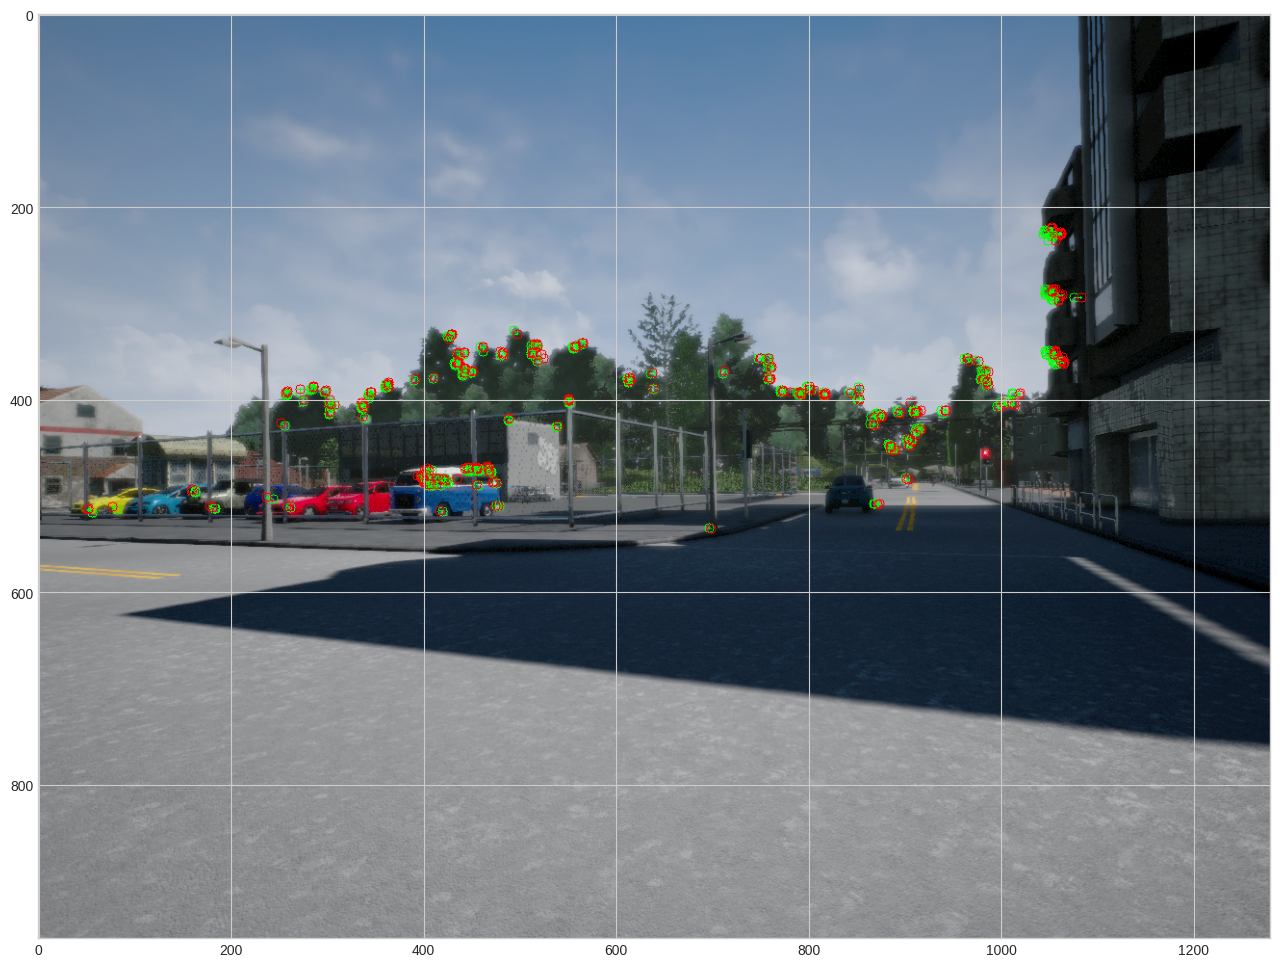

In [ ]:
i=0
image1  = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i + 1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

# These visualizations might be helpful for understanding the quality of image points selected for the camera motion estimation

### 3.2 - Оценка траектории камеры

**Задание**: Реализуйте оценку траектории камеры с помощью визуальной одометрии. В частности, реализуйте оценку движения камеры для каждой последующей пары изображений в наборе данных с помощью функции, которую вы написали в предыдущем разделе.

***Замечание***: Не забывайте, что пары изображений не являются независимыми друг от друга. i-я и (i + 1)-я пары изображений имеют общую часть

In [ ]:
'''
def estimate_trajectory0(estimate_motion, matches, kp_list, k, depth_maps=[]):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset.
               Each matches[i] is a list of matched features from images i and i + 1
    des_list -- a list of keypoints for each image in the dataset
    k -- camera calibration matrix

    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and
                  trajectory[:, i] is a 3x1 numpy vector, such as:

                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location

                  * Consider that the origin of your trajectory cordinate system is located at the camera position
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven
                  at the initialization of this function

    """
    trajectory = np.zeros((3, len(kp_list)))

    ### START CODE HERE ###

    # Assume the first location of the camera is at the origin
    trajectory[:, 0] = np.array([0, 0, 0])

    # Initialize the current transformation matrix to identity (no motion from the first frame)
    current_pose = np.eye(4)

    for i in range(len(matches)):
        # Use the matches, keypoints and potentially depth maps to estimate motion
        if depth_maps:
            motion = estimate_motion(matches[i], kp_list[i], kp_list[i+1], k, depth_maps[i])
        else:
            motion = estimate_motion(matches[i], kp_list[i], kp_list[i+1], k)

        # Update the current pose by multiplying with the estimated motion matrix
        current_pose = np.dot(current_pose, motion)

        # Extract the translation part and update the trajectory
        trajectory[:, i + 1] = current_pose[:3, 3]

    ### END CODE HERE ###
    return trajectory
'''

In [ ]:
'''
def estimate_trajectory1(estimate_motion, matches, kp_list, k, depth_maps=[]):
    # Initialize the trajectory with the origin at the first camera position
    trajectory = np.zeros((3, len(kp_list)))
    # Assume the first location of the camera is at the origin
    trajectory[:, 0] = np.array([0, 0, 0])

    # Initialize the current transformation matrix to identity (no motion from the first frame)
    current_pose = np.eye(4)

    for i in range(len(matches)):
        result = estimate_motion(matches[i], kp_list[i], kp_list[i+1], k, depth_maps[i] if depth_maps else None)

        # Извлекаем результаты: матрицу вращения, вектор перемещения
        rmat, tvec, _, _ = result

        # Формируем матрицу преобразования из вращения и перемещения
        motion = np.eye(4)
        motion[:3, :3] = rmat
        motion[:3, 3] = tvec.reshape(3)

        # Обновляем текущую позицию
        current_pose = np.dot(current_pose, motion)

        # Обновляем траекторию
        trajectory[:, i + 1] = current_pose[:3, 3]

    return trajectory

'''

In [ ]:
import numpy as np

def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=[]):
    trajectory = np.zeros((3, len(kp_list)))  # Траектория камеры
    trajectory[:, 0] = np.array([0, 0, 0])   # Начальное положение камеры
    current_pose = np.eye(4)                 # Текущее положение камеры

    for i in range(len(matches)):
        result = estimate_motion(matches[i], kp_list[i], kp_list[i+1], k, depth_maps[i] if depth_maps else None)

        if result is None:
            print(f"Движение для пары {i} не может быть оценено. Используется предыдущая поза.")
            continue  # Пропускаем обновление траектории для этого шага или используем default motion

        # Извлекаем результаты: матрицу вращения, вектор перемещения

        rmat, tvec, _, _ = result

        # Формируем матрицу преобразования из вращения и перемещения

        motion = np.eye(4)
        motion[:3, :3] = rmat
        motion[:3, 3] = tvec.flatten()  # Использование flatten для безопасности, если tvec уже одномерный

        # Обновляем текущую позицию
        current_pose = np.dot(current_pose, motion)
        # Обновляем траекторию
        trajectory[:, i + 1] = current_pose[:3, 3]

    return trajectory


In [ ]:


depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, filtered_matches, kp_list, k, depth_maps=depth_maps)

trajectory

array([[  0.        ,  -0.02718762,  -0.05166136,  -0.08049964,
         -0.12443909,  -0.158494  ,  -0.17293863,  -0.19905008,
         -0.23124024,  -0.27400937,  -0.283539  ,  -0.32334301,
         -0.34704182,  -0.34717239,  -0.32508973,  -0.27801927,
         -0.29309684,  -0.35213306,  -0.41474406,  -0.4825147 ,
         -0.55421284,  -0.60449392,  -0.66128181,  -0.7372548 ,
         -0.80758358,  -0.89281162,  -1.03415974,  -1.15769312,
         -1.31186964,  -1.44797608,  -1.64365812,  -1.84489413,
         -2.03447251,  -2.2241686 ,  -2.35703109,  -2.55554533,
         -2.73465662,  -2.91545128,  -3.1544053 ,  -3.41658955,
         -3.70189162,  -3.9847576 ,  -4.27092006,  -4.59967191,
         -4.93709553,  -5.31826313,  -5.70577843,  -6.05037089,
         -6.503131  ,  -6.78626064,  -7.22391524,  -7.58672868],
       [  0.        ,   0.02136037,   0.03817237,   0.03685603,
          0.06278675,   0.08964775,   0.12091041,   0.14639508,
          0.17990913,   0.20615032,   0

saffaf
 1.0
saffaf
 16.0
42


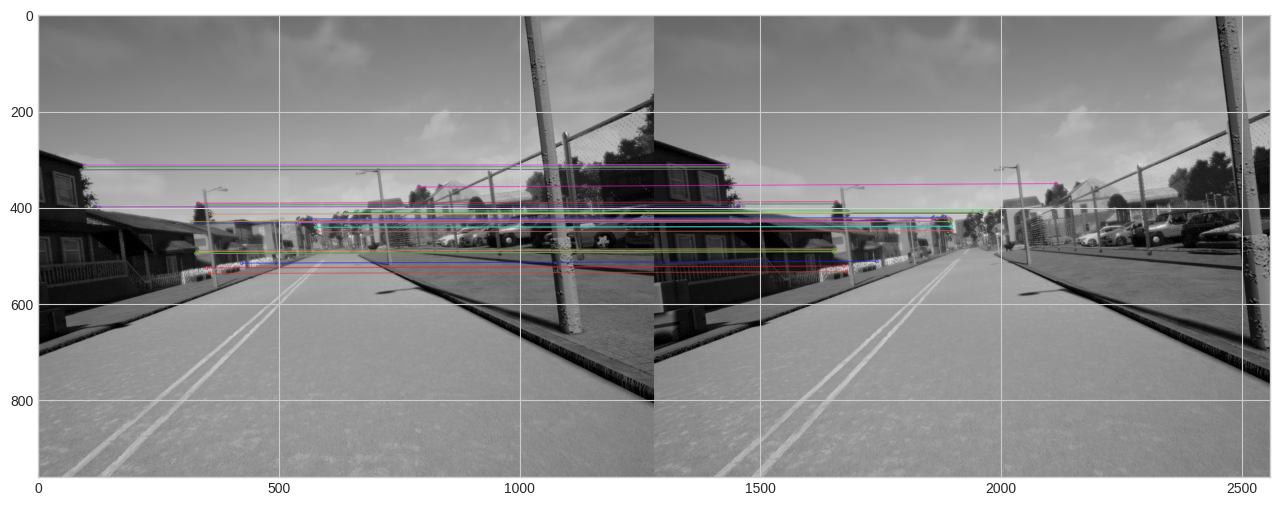

In [ ]:
# Визуализируйте первые n совпадений, поставьте n = None чтобы отобразить все совпадения
# установите filtering = True если хотите использовать фильтрацию совпадений, иначе поставьте False
n = None
filtering = True

i = 41
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
if filtering:
    match = filter_matches_distance(match, dist_threshold)

print(len(match))

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])

In [ ]:
i = 20
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))

Camera location in point 20 is: 
 [[-0.55421284]
 [ 0.42337928]
 [-7.85869171]]

Length of trajectory: 52


**Expected Output**:

```
Camera location in point i is:
 [[locXi]
 [locYi]
 [locZi]]```

 In this output: locXi, locYi, locZi are the coordinates of the corresponding i-th camera location

### Визуализируйте свои результаты


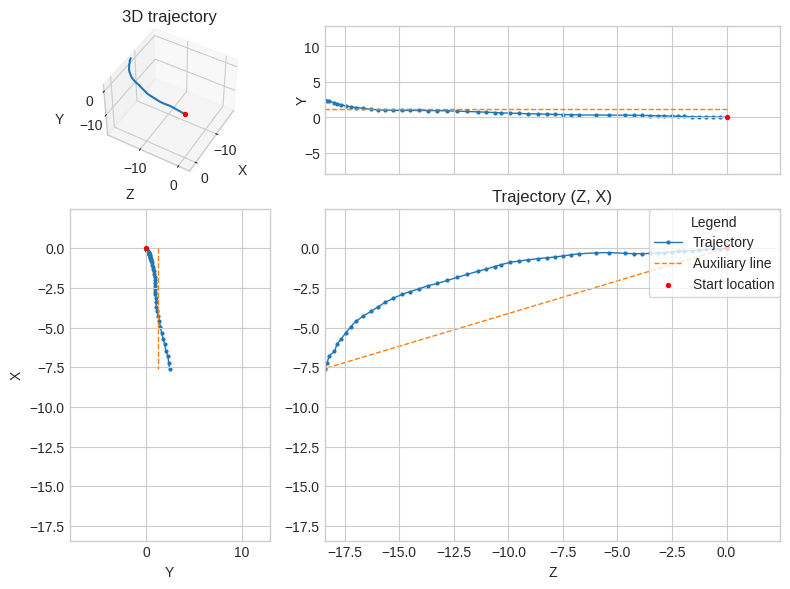

In [ ]:
visualize_trajectory(trajectory)

In [ ]:
# Загрузка изображений (пример)
# images - список всех изображений в наборе данных
# k - матрица калибровки камеры, depth_maps - список карт глубин

kp_list, des_list = [], []
for image in images:
    kp, des = extract_features(image)
    kp_list.append(kp)
    des_list.append(des)

# Сопоставление признаков и оценка движения
for i in range(len(images) - 1):
    matches = match_features(des_list[i], des_list[i+1])
    rmat, tvec, img1_pts, img2_pts = estimate_motion(matches, kp_list[i], kp_list[i+1], k, depth_maps[i])

    # Здесь можно добавить код для визуализации или дальнейшей обработки
    print("Rotation Matrix:\n", rmat)
    print("Translation Vector:\n", tvec)


Rotation Matrix:
 [[ 0.9999808  -0.00578965  0.00221116]
 [ 0.00579322  0.99998192 -0.0016092 ]
 [-0.0022018   0.00162198  0.99999626]]
Translation Vector:
 [[-0.02604554]
 [ 0.02129142]
 [-0.29804632]]
Rotation Matrix:
 [[ 9.99990938e-01 -4.15786969e-03  9.14656118e-04]
 [ 4.15955757e-03  9.99989635e-01 -1.85127500e-03]
 [-9.06949277e-04  1.85506279e-03  9.99997868e-01]]
Translation Vector:
 [[ 0.0049324 ]
 [ 0.01534461]
 [-0.38119539]]
Rotation Matrix:
 [[ 9.99994930e-01 -3.11543107e-03  6.59056642e-04]
 [ 3.11677650e-03  9.99993041e-01 -2.05036609e-03]
 [-6.52664281e-04  2.05240982e-03  9.99997681e-01]]
Translation Vector:
 [[-0.04044452]
 [-0.00196367]
 [-0.31545535]]
Rotation Matrix:
 [[ 9.99996876e-01 -2.35114440e-03  8.48189333e-04]
 [ 2.35350337e-03  9.99993336e-01 -2.79098994e-03]
 [-8.41621660e-04  2.79297744e-03  9.99995745e-01]]
Translation Vector:
 [[-0.04479152]
 [ 0.02455746]
 [-0.27836031]]
Rotation Matrix:
 [[ 0.99997721  0.00299989  0.00604808]
 [-0.00298528  0.999992